Install prerequisites and import appropriate functions

In [ ]:
%pip install pandas matplotlib scikit-learn seaborn ipympl
import pandas as pd
%matplotlib inline
#%matplotlib widget
#%matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from itertools import combinations


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Read input CSV from the folder and print it to confirm successful read

In [ ]:
df_pm = pd.read_csv('28-3-2023  -  10-31.csv',delimiter=',',header='infer')
df_pm

,DateTime,Fidas 200 PM2.5,SPS30 PM2.5,SEN55 PM2.5,HPMA115 PM2.5,NextPM PM2.5,SDS011 PM2.5
0,2023-3-28 10:32:6,19.39,13.63,12.5,28,0.0,9.1
1,2023-3-28 10:32:11,19.39,14.68,13.1,28,0.0,9.5
2,2023-3-28 10:32:17,19.36,15.27,13.7,17,0.0,9.8
3,2023-3-28 10:32:22,19.36,15.55,14.1,17,22.7,10.1
4,2023-3-28 10:32:28,19.36,15.79,14.4,17,23.5,10.0
...,...,...,...,...,...,...,...
15636,2023-3-29 10:51:39,19.16,16.04,13.7,15,24.0,10.8
15637,2023-3-29 10:51:44,19.16,15.88,13.8,17,19.9,10.2
15638,2023-3-29 10:51:50,19.16,15.21,13.7,17,16.7,10.3
15639,2023-3-29 10:51:56,19.16,14.98,13.3,17,12.5,10.5


Define deployed sensors, drop non deployed sensors, convert first column to pandas datetime remove any erroneous values

In [ ]:
# define the array of deployed sensors
deployed_sensors = ['Fidas 200 PM2.5', 'SPS30 PM2.5', 'SEN55 PM2.5', 'HPMA115 PM2.5', 'NextPM PM2.5', 'SDS011 PM2.5']

# loop over all columns in the dataframe and drop any that are not in the columns_to_keep array, except for 'DateTime'
for col in df_pm.columns:
    if col not in deployed_sensors and col != 'DateTime':
        df_pm = df_pm.drop(col, axis=1)
df_pm['DateTime'] = pd.to_datetime(df_pm.DateTime)

# filter the dataframe to exclude rows with negative values in deployed_sensors columns
df_pm = df_pm.loc[~(df_pm[deployed_sensors] < 0).any(axis=1)]

df_pm

,DateTime,Fidas 200 PM2.5,SPS30 PM2.5,SEN55 PM2.5,HPMA115 PM2.5,NextPM PM2.5,SDS011 PM2.5
0,2023-03-28 10:32:06,19.39,13.63,12.5,28,0.0,9.1
1,2023-03-28 10:32:11,19.39,14.68,13.1,28,0.0,9.5
2,2023-03-28 10:32:17,19.36,15.27,13.7,17,0.0,9.8
3,2023-03-28 10:32:22,19.36,15.55,14.1,17,22.7,10.1
4,2023-03-28 10:32:28,19.36,15.79,14.4,17,23.5,10.0
...,...,...,...,...,...,...,...
15636,2023-03-29 10:51:39,19.16,16.04,13.7,15,24.0,10.8
15637,2023-03-29 10:51:44,19.16,15.88,13.8,17,19.9,10.2
15638,2023-03-29 10:51:50,19.16,15.21,13.7,17,16.7,10.3
15639,2023-03-29 10:51:56,19.16,14.98,13.3,17,12.5,10.5


Plot initial graph

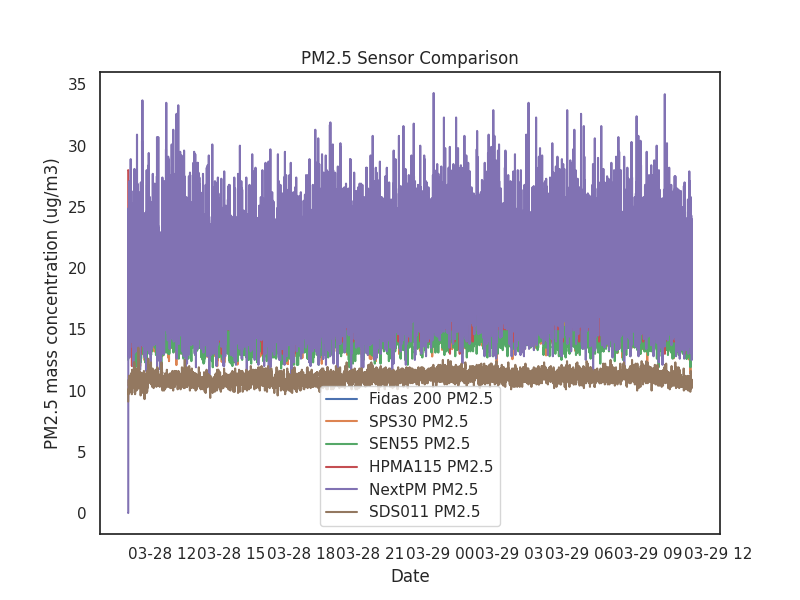

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

Plot every pair of sensors against each other

In [ ]:

# create a figure object with subplots
fig, axs = plt.subplots(len(deployed_sensors), len(deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(deployed_sensors)):
    for j in range(len(deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

Plot correlation matrix

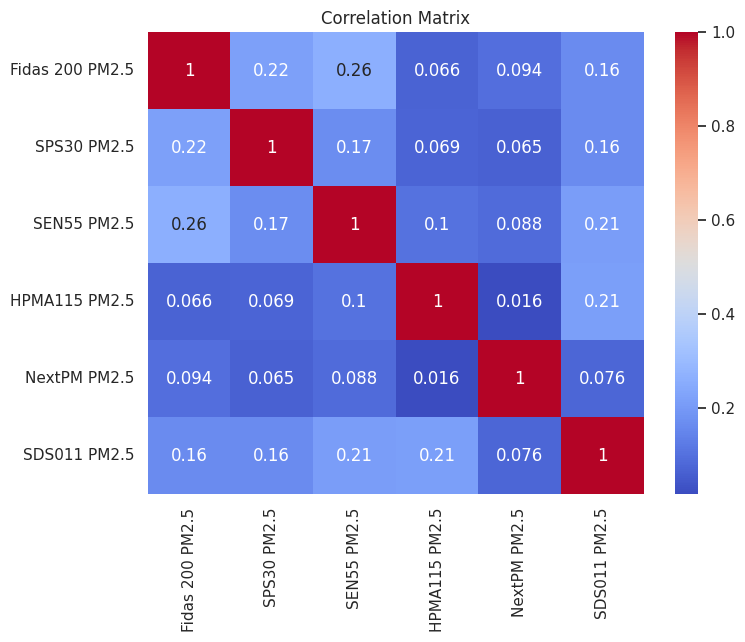

In [ ]:
# create a correlation matrix for the selected columns
corr = df_pm[deployed_sensors].corr()

# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Calculate r squared between all sensors


In [ ]:
# create an empty list to store the R-squared values
r_squared_list = []

# loop through all possible combinations of columns and calculate R-squared
for pair in combinations(deployed_sensors, 2):
    x_col = df_pm[pair[0]]
    y_col = df_pm[pair[1]]
    r_squared = r2_score(x_col, y_col)
    r_squared_list.append((pair[0], pair[1], r_squared))

# sort the list of R-squared values in descending order
r_squared_list.sort(key=lambda x: x[2], reverse=True)

# print the R-squared values
for r in r_squared_list:
    print(f"R-squared between '{r[0]}' and '{r[1]}': {r[2]}")

R-squared between 'SPS30 PM2.5' and 'SEN55 PM2.5': -0.9287552739914942
R-squared between 'NextPM PM2.5' and 'SDS011 PM2.5': -6.747845997591104
R-squared between 'SPS30 PM2.5' and 'HPMA115 PM2.5': -7.649348874982216
R-squared between 'HPMA115 PM2.5' and 'NextPM PM2.5': -9.953358498373518
R-squared between 'SEN55 PM2.5' and 'HPMA115 PM2.5': -15.716969246209818
R-squared between 'SEN55 PM2.5' and 'SDS011 PM2.5': -18.229917091998157
R-squared between 'SPS30 PM2.5' and 'SDS011 PM2.5': -18.828557596358
R-squared between 'Fidas 200 PM2.5' and 'HPMA115 PM2.5': -19.190724394013966
R-squared between 'HPMA115 PM2.5' and 'SDS011 PM2.5': -20.817889212626202
R-squared between 'Fidas 200 PM2.5' and 'NextPM PM2.5': -26.93505997200225
R-squared between 'SPS30 PM2.5' and 'NextPM PM2.5': -40.52737777317512
R-squared between 'Fidas 200 PM2.5' and 'SPS30 PM2.5': -54.655901917099705
R-squared between 'SEN55 PM2.5' and 'NextPM PM2.5': -66.42625749499406
R-squared between 'Fidas 200 PM2.5' and 'SEN55 PM2.5': 

Perform data smoothing

/tmp/ipykernel_65035/1927228343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[f"{col} Smoothed"] = df_pm[col].rolling(window=numtoaverage).mean()
/tmp/ipykernel_65035/1927228343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[f"{col} Smoothed"] = df_pm[col].rolling(window=numtoaverage).mean()
/tmp/ipykernel_65035/1927228343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

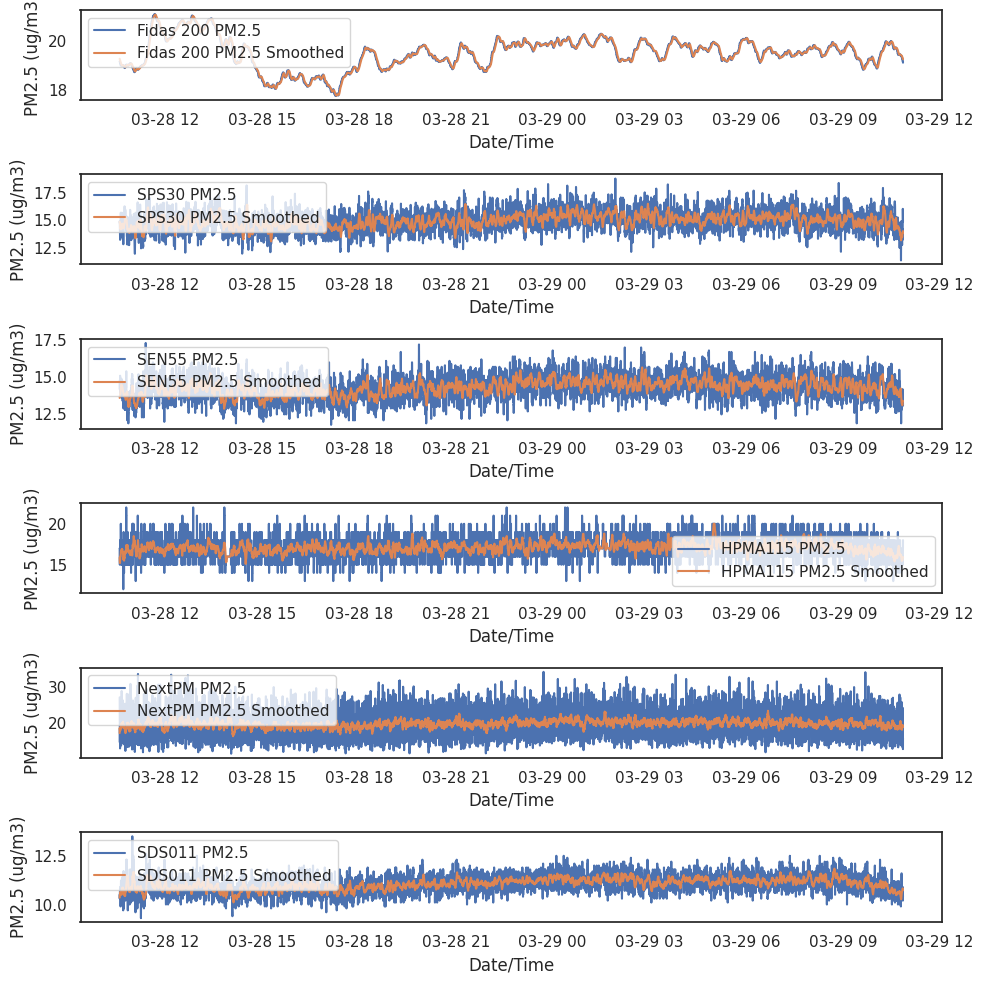

In [ ]:
numtoaverage = 30

# loop through each column and perform a 30 point rolling average
for col in deployed_sensors:
    df_pm[f"{col} Smoothed"] = df_pm[col].rolling(window=numtoaverage).mean()

# drop the first 30 rows to avoid NaN values
df_pm = df_pm.iloc[numtoaverage:]

# plot the original and smoothed values for each column
fig, axes = plt.subplots(nrows=len(deployed_sensors), ncols=1, figsize=(10,10))
for i, col in enumerate(deployed_sensors):
    ax = axes[i]
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)
    ax.plot(df_pm['DateTime'], df_pm[f"{col} Smoothed"], label=f"{col} Smoothed")
    ax.set_xlabel('Date/Time')
    ax.set_ylabel('PM2.5 (ug/m3)')
    ax.legend()
plt.tight_layout()
plt.show()






Evaluate correlation for each smoothed element

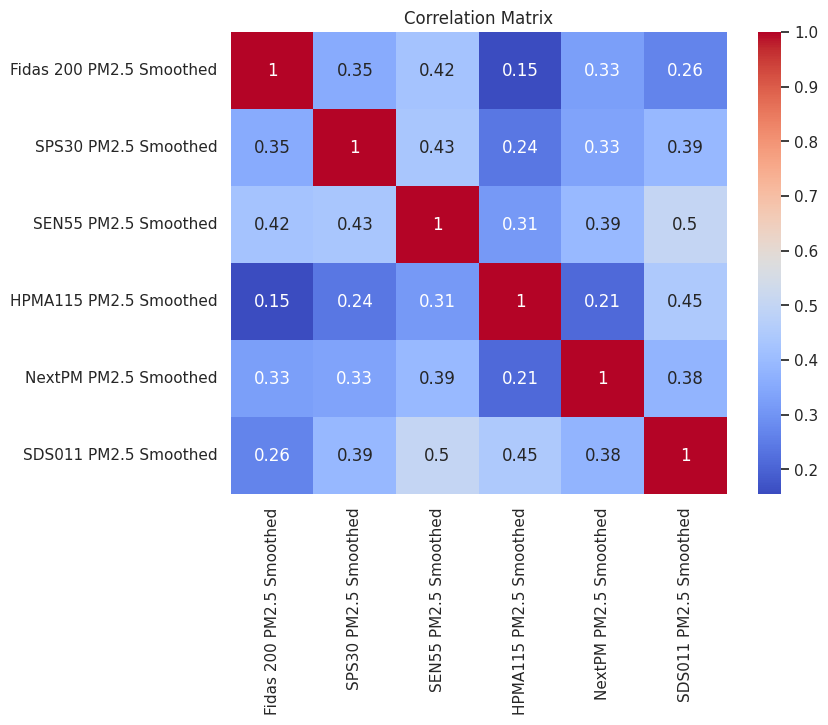

In [ ]:
smoothed_deployed_sensors = [elem + " Smoothed" for elem in deployed_sensors]


# create a correlation matrix for the selected columns
corr2 = df_pm[smoothed_deployed_sensors].corr()

# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Evaluate R Squared for smoothed data

In [ ]:
# create an empty list to store the R-squared values
smoothed_r_squared_list = []

# loop through all possible combinations of columns and calculate R-squared
for pair in combinations(smoothed_deployed_sensors, 2):
    x_col = df_pm[pair[0]]
    y_col = df_pm[pair[1]]
    r_squared = r2_score(x_col, y_col)
    smoothed_r_squared_list.append((pair[0], pair[1], r_squared))

# sort the list of R-squared values in descending order
smoothed_r_squared_list.sort(key=lambda x: x[2], reverse=True)

# print the R-squared values
for r in smoothed_r_squared_list:
    print(f"R-squared between '{r[0]}' and '{r[1]}': {r[2]}")

R-squared between 'SPS30 PM2.5 Smoothed' and 'SEN55 PM2.5 Smoothed': -1.2522309282924748
R-squared between 'Fidas 200 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': -1.363630655428008
R-squared between 'SPS30 PM2.5 Smoothed' and 'HPMA115 PM2.5 Smoothed': -15.40852570408352
R-squared between 'Fidas 200 PM2.5 Smoothed' and 'HPMA115 PM2.5 Smoothed': -15.616118795523366
R-squared between 'HPMA115 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': -22.174097313807945
R-squared between 'SEN55 PM2.5 Smoothed' and 'HPMA115 PM2.5 Smoothed': -35.32043890809016
R-squared between 'SEN55 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': -47.71369153118597
R-squared between 'SPS30 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': -48.72253070125138
R-squared between 'Fidas 200 PM2.5 Smoothed' and 'SPS30 PM2.5 Smoothed': -53.55884378996621
R-squared between 'Fidas 200 PM2.5 Smoothed' and 'SEN55 PM2.5 Smoothed': -68.99075982412784
R-squared between 'SPS30 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': -73.46402386460427


Plot smoothed data against each other

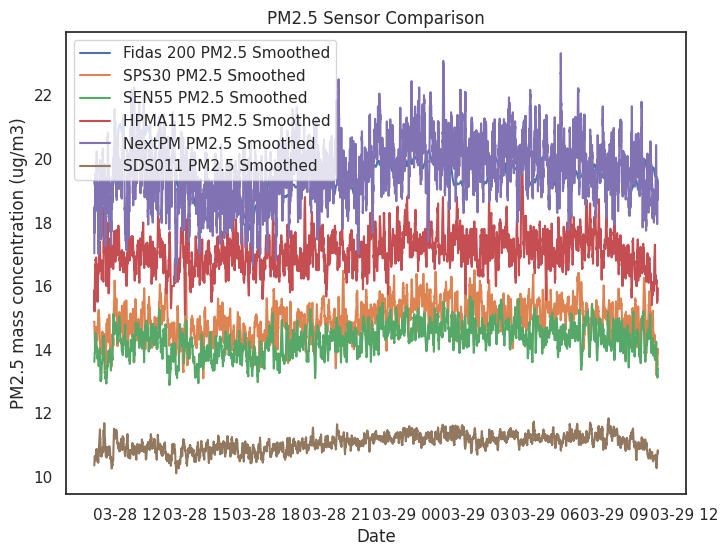

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in smoothed_deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

Run mass plotting again with smoothed data

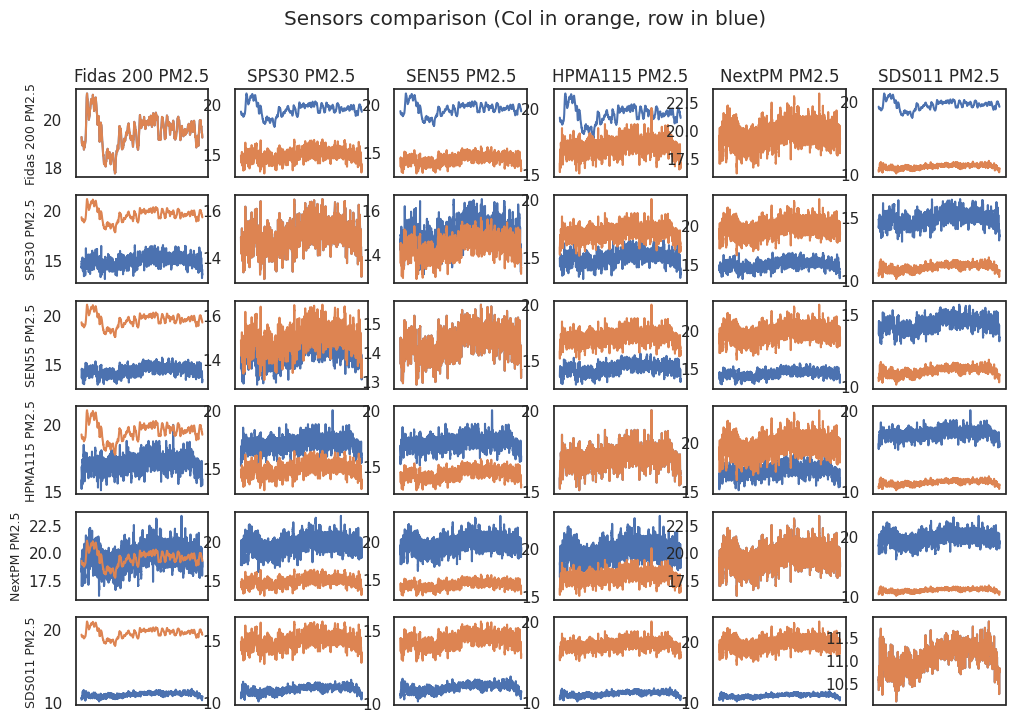

In [ ]:
# create a figure object with subplots
fig, axs = plt.subplots(len(smoothed_deployed_sensors), len(smoothed_deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(smoothed_deployed_sensors)):
    for j in range(len(smoothed_deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[smoothed_deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[smoothed_deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()
